In [ ]:
import tensorflow

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from keras.layers import Flatten,MaxPooling2D,Dropout

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, load_model

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow-version:", tensorflow.__version__)

import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount("/content/drive/")

Tensorflow-version: 2.8.0
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%tensorflow_version 2.0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.7576808889999995
GPU (s):
0.04501048899999205
GPU speedup over CPU: 83x


# **Accessing the Dataset**

In [ ]:
os.getcwd()
os.chdir("/content/drive/My Drive/Food-11 image dataset/")
target_labels = ["Bread", 
                 "Dairy product", 
                 "Dessert", 
                 "Egg", 
                 "Fried food", 
                 "Meat", 
                 "Noodles-Pasta", 
                 "Rice", 
                 "Seafood", 
                 "Soup", 
                 "Vegetable-Fruit"]
path = "/content/drive/My Drive/Food-11 image dataset/"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from keras.applications import densenet

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=densenet.preprocess_input
        )

validate_datagen = ImageDataGenerator( preprocessing_function = densenet.preprocess_input
                                      )
test_datagen = ImageDataGenerator(
        preprocessing_function=densenet.preprocess_input
    )

In [ ]:
BATCH_SIZE=64

In [ ]:
train_generator = train_datagen.flow_from_directory(path+"training",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validate_generator = validate_datagen.flow_from_directory(path+"validation",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(path+"evaluation",
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes= target_labels,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             seed=42)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


# **DenseNet-121**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from keras.layers import Flatten,MaxPooling2D,Dropout
from keras.models import Model



In [ ]:
basemodel= DenseNet121(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
    )

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
basemodel.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
for layer in basemodel.layers:
	layer.trainable = False

In [ ]:
x=basemodel.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(11,activation='softmax')(x) #FC-layer

In [ ]:
model=Model(inputs=basemodel.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# **Compile the Model**

In [ ]:
from tensorflow.keras.optimizers import Adam

opt =  tensorflow.keras.optimizers.Adam(learning_rate=.01)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.01,
    patience = 10,
    restore_best_weights = True,
)

In [ ]:
from keras.callbacks import ModelCheckpoint  
filepath="/content/drive/My Drive/Food-11 image dataset/DENSENET-121-MODEL{epoch:02d}-{val_accuracy:.2f}.hdf5"

# the ModelCheckpoint mentioned here will save the model after an epoch if the "val-accuracy" has increased. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
densenet_history = model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    epochs = 15,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint, earlystopping],
    verbose=1
)

Epoch 1/15
154/154 [==============================] - ETA: 0s - loss: 1.1030 - accuracy: 0.6705 
Epoch 1: val_accuracy improved from -inf to 0.82282, saving model to /content/drive/My Drive/Food-11 image dataset/DENSENET-121-MODEL01-0.82.hdf5
154/154 [==============================] - 2860s 19s/step - loss: 1.1030 - accuracy: 0.6705 - val_loss: 0.5575 - val_accuracy: 0.8228
Epoch 2/15
154/154 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.7567
Epoch 2: val_accuracy did not improve from 0.82282
154/154 [==============================] - 237s 2s/step - loss: 0.7462 - accuracy: 0.7567 - val_loss: 0.6065 - val_accuracy: 0.8166
Epoch 3/15
154/154 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.7738
Epoch 3: val_accuracy improved from 0.82282 to 0.82989, saving model to /content/drive/My Drive/Food-11 image dataset/DENSENET-121-MODEL03-0.83.hdf5
154/154 [==============================] - 241s 2s/step - loss: 0.6775 - accuracy: 0.7738 - val_los

In [ ]:
# converting the epochs history to data frame and saving in drive
densenet_history_frame = pd.DataFrame(densenet_history.history)

In [ ]:
densenet_history_frame.to_csv("densenet_history.csv")
!cp densenet_history.csv path

In [ ]:
densenet_history_frame = pd.read_csv("densenet_history.csv")
densenet_history_frame.index  = np.arange(1,15) 
densenet_history_frame.head(2)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
1,0,1.102981,0.670475,0.557461,0.822818
2,1,0.746197,0.756682,0.606488,0.816627


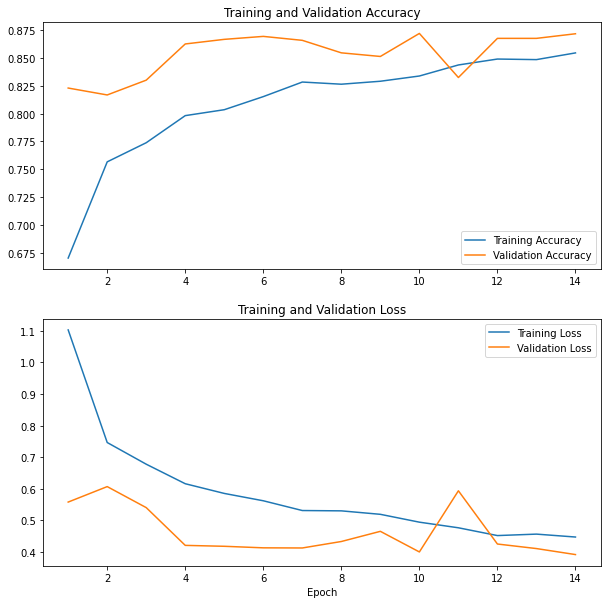

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(densenet_history_frame['accuracy'], label='Training Accuracy')
plt.plot(densenet_history_frame['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(densenet_history_frame['loss'], label='Training Loss')
plt.plot(densenet_history_frame['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# **Fine-Tuning**

In [ ]:
for i,layer in enumerate(basemodel.layers):
    print(i,layer.name)

0 input_1
1 zero_padding2d
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_1
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block6_

In [ ]:
#Convolution Base transforms to True
basemodel.trainable = True

In [ ]:
#Excluding the last nine layers, trainable is set to False. Weights are also frozen for all layers except the last 9.
for layer in basemodel.layers[:-9]:
    layer.trainable=False

#For the last 9 layers, trainable is set to True. (the last convolutional block in DENSENET121). Weight is unfrozen for those respective layers.
for layer in basemodel.layers[-9:]:
    layer.trainable=True

In [ ]:
for layer in basemodel.layers[:-9]:
    layer.trainable=False

for layer in basemodel.layers[-9:]:
    layer.trainable=True

In [ ]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.01,
    patience = 10,
    restore_best_weights = True,
)

In [ ]:
from tensorflow.keras.optimizers import Adam

opt =  tensorflow.keras.optimizers.Adam(learning_rate=.0001)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

filepath_ft="/content/drive/My Drive/Food-11 image dataset/DENSENET121-FT-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint_ft = ModelCheckpoint(filepath_ft, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_ft = [checkpoint_ft]

In [ ]:
# fine tune the already trained model
densenet121_ft_history = model.fit(
    train_generator, 
    batch_size=64,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    epochs = 15,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint_ft, earlystopping,anne],
    verbose=1
)

Epoch 1/15
154/154 [==============================] - ETA: 0s - loss: 0.5615 - accuracy: 0.8118
Epoch 1: val_accuracy improved from -inf to 0.86498, saving model to /content/drive/My Drive/Food-11 image dataset/DENSENET121-FT-01-0.86.hdf5
154/154 [==============================] - 266s 2s/step - loss: 0.5615 - accuracy: 0.8118 - val_loss: 0.4061 - val_accuracy: 0.8650 - lr: 1.0000e-04
Epoch 2/15
154/154 [==============================] - ETA: 0s - loss: 0.5206 - accuracy: 0.8286
Epoch 2: val_accuracy improved from 0.86498 to 0.86616, saving model to /content/drive/My Drive/Food-11 image dataset/DENSENET121-FT-02-0.87.hdf5
154/154 [==============================] - 236s 2s/step - loss: 0.5206 - accuracy: 0.8286 - val_loss: 0.3997 - val_accuracy: 0.8662 - lr: 1.0000e-04
Epoch 3/15
154/154 [==============================] - ETA: 0s - loss: 0.4897 - accuracy: 0.8368
Epoch 3: val_accuracy improved from 0.86616 to 0.87176, saving model to /content/drive/My Drive/Food-11 image dataset/DENSENE

In [ ]:
densenet121_ft_history_frame = pd.DataFrame(densenet121_ft_history.history)

In [ ]:
densenet121_ft_history_frame.to_csv("densenet121_ft_history_frame.csv")
!cp densenet121_ft_history_frame.csv path

In [ ]:
densenet121ft_history_frame = pd.read_csv("densenet121_ft_history_frame.csv")
densenet121_ft_history_frame.index = np.arange(1, 16)
densenet121_ft_history_frame.head(2)

,loss,accuracy,val_loss,val_accuracy,lr
1,0.561528,0.811773,0.406129,0.864976,0.0001
2,0.520626,0.828606,0.399672,0.866156,0.0001


In [ ]:
densenet121_full_history = pd.concat([densenet121_ft_history_frame], axis=0)

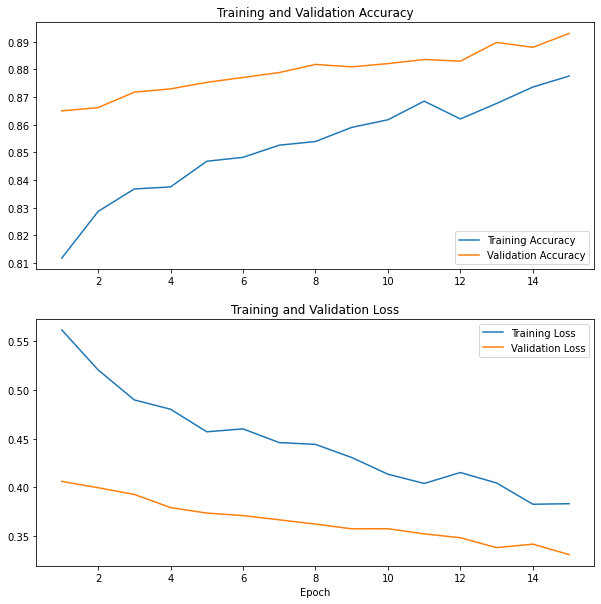

In [ ]:
acc = densenet121_full_history["accuracy"]
val_acc = densenet121_full_history['val_accuracy']

loss = densenet121_full_history['loss']
val_loss = densenet121_full_history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# **Combining Both**

In [ ]:
dn_full_history = pd.concat([densenet_history_frame, densenet121_ft_history_frame], axis=0)

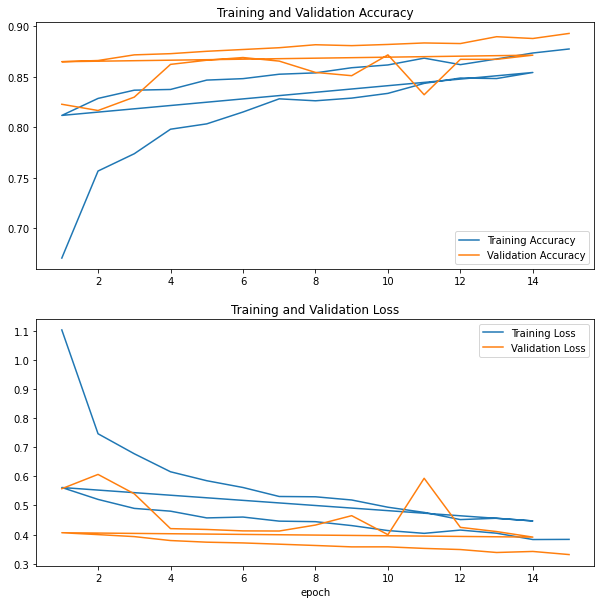

In [ ]:
acc = dn_full_history["accuracy"]
val_acc = dn_full_history['val_accuracy']

loss = dn_full_history['loss']
val_loss = dn_full_history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.plot([initial_epoch-1,initial_epoch-1],
#           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.plot([initial_epoch-1,initial_epoch-1],
#          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Evaluation of Model using Test Generator**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# a function to evaluate the prediction of dataset from a given model
def model_evaluation(model, generator):
  generator.reset() # There is a reset() method for the datagenerators which resets it to the first batch. So whenever you would want to correlate the model output with the filenames you need to set shuffle as False and reset the datagenerator before performing any prediction. This will ensure that our files are being read properly and there is nothing wrong with them.

  true_classes = generator.classes
  class_indices = dict((v,k) for k,v in generator.class_indices.items())
  preds = model.predict(generator)
  preds_classes = np.argmax(preds, axis=1)
  return [true_classes, preds_classes, generator.class_indices.keys()]

In [ ]:
# for the prediction made, this function prints a confusion matrix 
def plot_confusion_matrix(true_classes, preds_classes, target_names):
  cm = confusion_matrix(true_classes, preds_classes)

  df_cm = pd.DataFrame(cm, columns=target_names, index = target_names)
  plt.figure(figsize=(12,12))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, annot=True, fmt='g', cbar=False, cmap="rocket_r") # font size , annot_kws={"size": 16}
  plt.title('Confusion Matrix\n', y=1.1)
  plt.ylabel('Actual Label\n')
  plt.xlabel('Predicted Label\n')

  plt.show()

In [ ]:
result = model_evaluation(model, test_generator)
true_classes, preds_classes, target_names = result[0], result[1], result[2]
test_ft_acc=accuracy_score(true_classes, preds_classes) 
print("Densenet-121 WITH Fine-Tuning on Testing Set has Accuracy: {:.2f}%".format(test_ft_acc * 100))

Densenet-121 WITH Fine-Tuning on Testing Set has Accuracy: 90.80%


In [ ]:
print(classification_report(true_classes, preds_classes,target_names =  target_names))

                 precision    recall  f1-score   support

          Bread       0.88      0.82      0.85       368
  Dairy product       0.87      0.84      0.86       148
        Dessert       0.91      0.83      0.87       500
            Egg       0.80      0.91      0.85       335
     Fried food       0.85      0.90      0.87       287
           Meat       0.91      0.94      0.92       432
  Noodles-Pasta       0.99      0.98      0.98       147
           Rice       0.97      0.97      0.97        96
        Seafood       0.92      0.94      0.93       303
           Soup       0.98      0.97      0.97       500
Vegetable-Fruit       0.98      0.97      0.97       231

       accuracy                           0.91      3347
      macro avg       0.91      0.91      0.91      3347
   weighted avg       0.91      0.91      0.91      3347



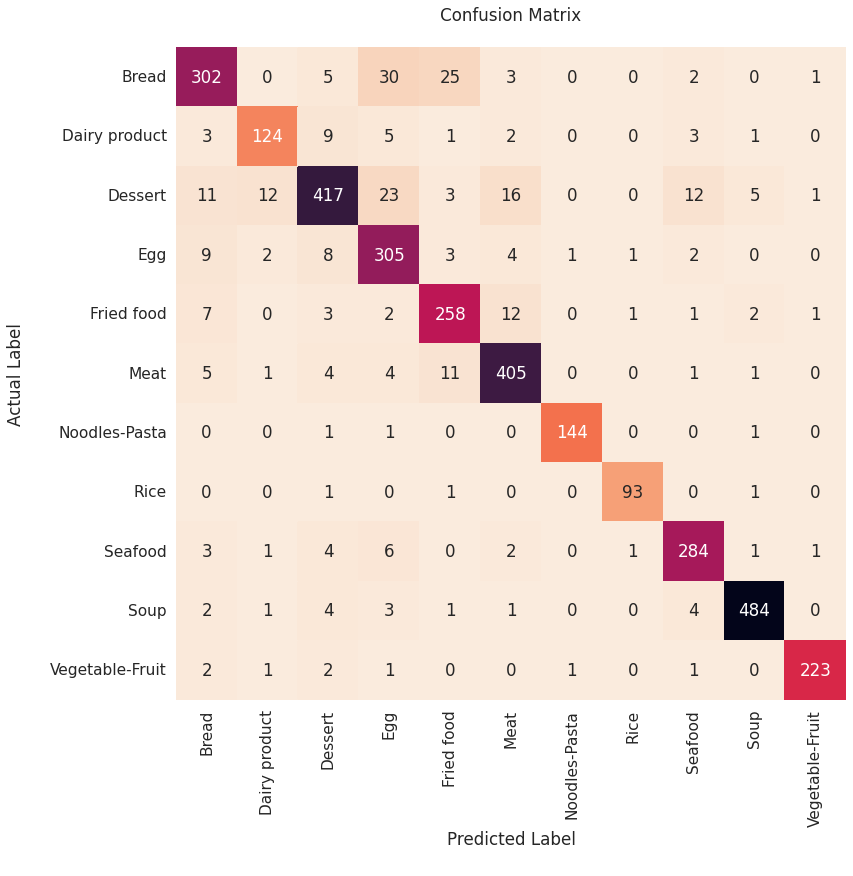

In [ ]:
plot_confusion_matrix(true_classes, preds_classes, target_names)